In [1]:
from collections import deque
from collections import namedtuple
from math import sqrt
from pymonad.tools import curry
from functools import reduce

In [2]:
# the named tuple types
sumstats_type = namedtuple("sumstats",["value","domain","cardinality","capacity","push"])
normal_mean_segment_cost_type = namedtuple("normal_mean_segment_cost",["value","domain","cardinality"])
left_cost_type = namedtuple("left_cost",["value","domain","cardinality"])
right_cost_type = namedtuple("right_cost",["value","domain","cardinality"])
left_right_cost_type = namedtuple("left_right_cost",["value","domain","cardinality"])
normal_mean_type = namedtuple("normal_mean",["value","domain","cardinality","capacity","push"])
amoc_online_type = namedtuple("amoc_online",["push","size"])
window_function_type = namedtuple("window_function",["value","domain","graph","cardinality","push","insert"])

In [3]:
def class_sumstats(size = None) : # sumstats class (a factory)
    wsize = size if size == None else size + 1 
    sumstats = deque([(0.0,0.0,0.0)],wsize)
    def cardinality() :
        nonlocal sumstats
        return len(sumstats) - 1 
    def domain() :
        nonlocal sumstats
        return range(len(sumstats)-1)
    def push(y) :
        nonlocal sumstats,wsize
        last = sumstats[-1]
        sumstats.append((y,last[1] + y,last[2] + y*y))
        if len(sumstats) == sumstats.maxlen :
            y0,sy0,syy0 = sumstats[0]
            sumstats = deque([(y - y0,sy - sy0,syy - syy0) for y,sy,syy in sumstats],
                             wsize)
        return value,domain,cardinality,capacity,push
    def capacity() :
        nonlocal wsize
        return inf if wsize == None else wsize
    def value(i) :
        return sumstats[i]
    return sumstats_type(value,domain,cardinality,capacity,push)

In [4]:
def class_normal_mean_segment_cost(sumstats) :
    def cardinality() :
        nonlocal sumstats
        n = sumstats.cardinality()
        return int(n*(n+1)/2)
    def value(a,b) :
        nonlocal sumstats
        _,sya,syya = sumstats.value(a)
        _,syb,syyb = sumstats.value(b+1)
        val = syb - sya
        val *= val
        val /= (b - a + 1)
        val = -val
        val += syyb - syya
        return val
    def domain() :
        nonlocal sumstats
        outer = sumstats.domain()
        for a in outer :
            inner = sumstats.domain()
            for b in inner :
                if b >= a :
                    yield (a,b)
    return normal_mean_segment_cost_type(value,domain,cardinality)

In [5]:

def class_right_cost(segment_cost) :
    def cardinality() :
        nonlocal segment_cost
        return int((sqrt(8*segment_cost.cardinality()+1)-1)/2)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal segment_cost
        return segment_cost.value(i,cardinality()-1)
    return right_cost_type(value,domain,cardinality)

def class_left_cost(segment_cost) :
    def cardinality() :
        nonlocal segment_cost
        return int((sqrt(8*segment_cost.cardinality()+1)-1)/2)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal segment_cost
        return segment_cost.value(0,i)
    return left_cost_type(value,domain,cardinality)

In [6]:
def class_left_right_cost(left_cost,right_cost) :
    def value(i) :
        nonlocal left_cost,right_cost
        res = right_cost.value(i)
        if i == 0 :
            return res
        return left_cost.value(i-1) + res
    return left_right_cost_type(value,right_cost.domain,right_cost.cardinality)

In [7]:
def class_window_function(wsize) :
    ordered = deque([],maxlen=wsize)
    def cardinality() :
        nonlocal ordered
        return len(ordered)
    def domain() :
        return range(cardinality())
    def value(i) :
        nonlocal ordered
        return ordered[i]
    def push(val) :
        nonlocal ordered
        ordered.append(val)
        return window_function_type(value,domain,graph,cardinality,push,insert)
    def insert(i,x) :
        nonlocal ordered
        ordered.insert(i,x)
        return window_function_type(value,domain,graph,cardinality,push,insert)
    def graph() :
        for i in domain() :
            yield (i,value(i))
    return window_function_type(value,domain,graph,cardinality,push,insert)

In [8]:
def normal_mean(f) :
    sumstats = class_sumstats(f.cardinality())
    for _,x in f.graph() :
        sumstats.push(x)
    cost = class_normal_mean_segment_cost(sumstats)
    return normal_mean_type(cost.value,cost.domain,cost.cardinality,sumstats.capacity,sumstats.push)

In [9]:
def split(cost) :
    vmin,loc = min([(cost.value(i),i) for i in cost.domain()])
    return (cost.value(0) - vmin,loc)

In [10]:
@curry(3)
def scale(centre,dispersion,f) :
    g = class_window_function(f.cardinality())
    if f.cardinality() < 2 :
        g.push(0)
    else :
        mu = centre([x for _,x in f.graph()])
        sigma = dispersion([x for _,x in f.graph()])
        for _,x in f.graph() :
            g.push((x-mu)/sigma)
    return g

In [11]:
def compose(*funcs):
    return reduce(lambda f,g : lambda x : f(g(x)), funcs, lambda x : x)

In [12]:
def class_amoc_online(wsize,cost) :
    push = compose(split,
                   lambda x : class_left_right_cost(class_left_cost(x),class_right_cost(x)),
                   cost,
                   class_window_function(wsize).push)        
    return amoc_online_type(push,class_left_cost(cost).cardinality)

## Examples

In [20]:
from statistics import mean,stdev
import numpy as np
import matplotlib.pyplot as plt
from math import log

### Gaussian

#### generate some data

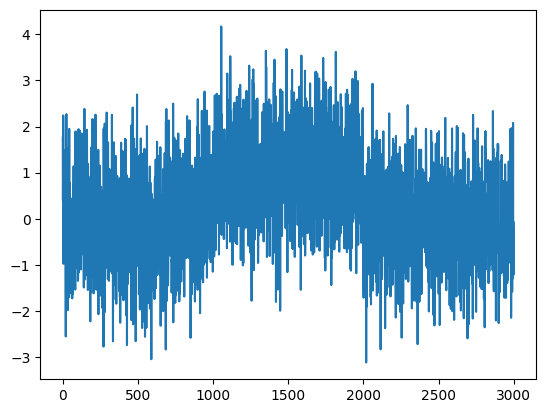

In [32]:
# create a simple example time series

np.random.seed(0)

Z = [float(z) for z in list(np.random.normal(0, 1, 1000)) + 
    list(np.random.normal(1, 1, 1000)) + 
    list(np.random.normal(0, 1, 1000))]

# visualise the data
plt.plot(Z)

In [33]:
wsize = 400
cost = compose(normal_mean,scale(mean,stdev))
sampler = class_amoc_online(wsize,cost)
history = list()
for z in Z :
    res = sampler.push(z)
    history.append(res)


In [35]:

for i,(severity,location) in zip(list(range(len(history))),history) :
    if severity > 3*log(wsize) :
        print("alarm at epoch " + str(i) + " at window position " + str(location)) 

alarm at epoch 1013 at window position 386
alarm at epoch 1014 at window position 385
alarm at epoch 1015 at window position 384
alarm at epoch 1016 at window position 383
alarm at epoch 1017 at window position 303
alarm at epoch 1018 at window position 302
alarm at epoch 1019 at window position 380
alarm at epoch 1020 at window position 379
alarm at epoch 1021 at window position 378
alarm at epoch 1022 at window position 377
alarm at epoch 1023 at window position 376
alarm at epoch 1024 at window position 375
alarm at epoch 1025 at window position 374
alarm at epoch 1026 at window position 373
alarm at epoch 1027 at window position 372
alarm at epoch 1028 at window position 371
alarm at epoch 1029 at window position 370
alarm at epoch 1030 at window position 369
alarm at epoch 1031 at window position 368
alarm at epoch 1032 at window position 367
alarm at epoch 1033 at window position 366
alarm at epoch 1034 at window position 365
alarm at epoch 1035 at window position 364
alarm at ep